In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import multivariate_normal as mvn

import vsem_jax as vsem
from vsem_inv_prob import InvProb, VSEMPrior, VSEMLikelihood

import sys
sys.path.append("./../linear_Gaussian/")
from Gaussian import Gaussian

rng = np.random.default_rng(6435)


# Exact Inverse Problem

In [5]:
n_days = 365 * 2
par_names = ["kext", "av"]

# For exact MCMC
proposal_cov = np.diag([0.3**2, 0.04**2])

likelihood = VSEMLikelihood(rng, n_days, par_names)
prior = VSEMPrior(likelihood.par_names, rng)
inv_prob = InvProb(rng, prior, likelihood,proposal_cov=proposal_cov)

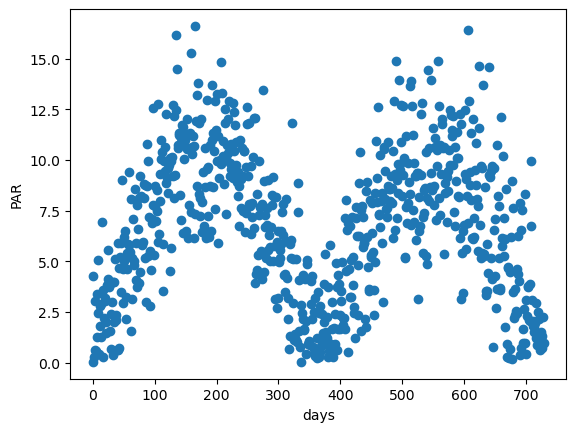

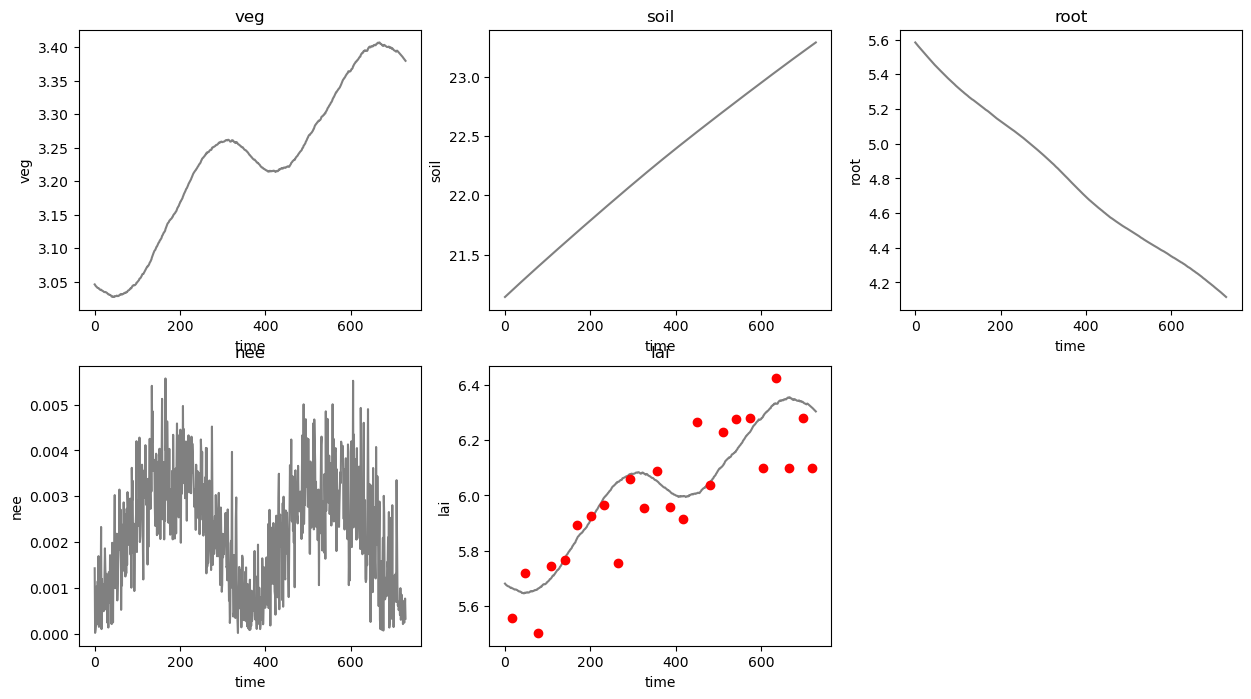

In [3]:
likelihood.plot_driver()
likelihood.plot_ground_truth()

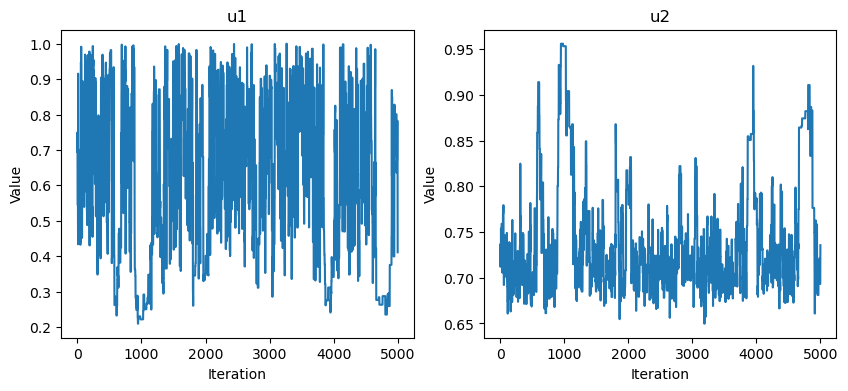

In [6]:
inv_prob.reset_sampler()
samp, trace_plot = inv_prob.sample_posterior(n_step=10000)

display(trace_plot)

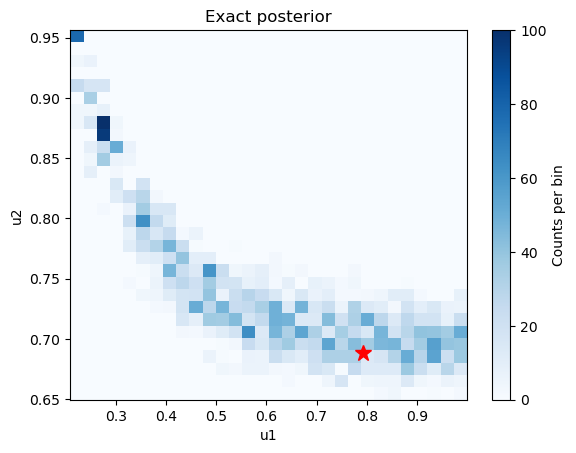

In [7]:
plt.hist2d(samp[:,0], samp[:,1], bins=30, cmap='Blues')
plt.plot(*likelihood.par_true, "*", color="red", markersize=12)
plt.colorbar(label='Counts per bin')
plt.xlabel('u1')
plt.ylabel('u2')
plt.title('Exact posterior')
plt.show()

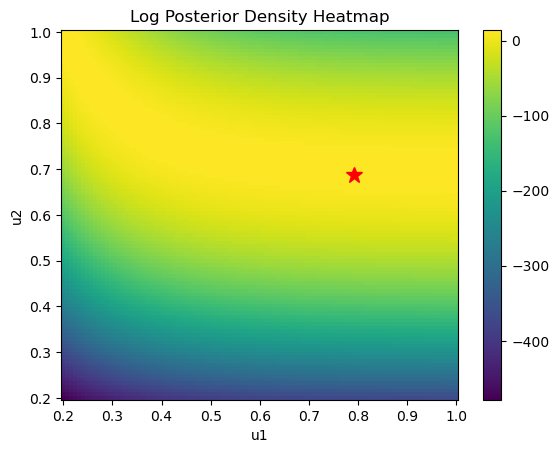

In [8]:
n_grid_1d = 100
u1_supp = prior.dists[par_names[0]].support()
u2_supp = prior.dists[par_names[1]].support()
u1_grid = np.linspace(u1_supp[0], u1_supp[1], n_grid_1d)
u2_grid = np.linspace(u2_supp[0], u2_supp[1], n_grid_1d)

U1_grid, U2_grid = np.meshgrid(u1_grid, u2_grid, indexing='xy')
U = np.stack([U1_grid.ravel(), U2_grid.ravel()], axis=1)
log_post_grid = inv_prob.log_posterior_density(U)
log_post = log_post_grid.reshape(U1_grid.shape)

plt.pcolormesh(U1_grid, U2_grid, log_post, shading='auto', cmap='viridis')
plt.plot(*likelihood.par_true, "*", color="red", markersize=12)
plt.title("Log Posterior Density Heatmap")
plt.xlabel("u1")
plt.ylabel("u2")
plt.colorbar()
plt.show()

# GP Surrogate Model

In [9]:
# Initial design for emulator
# Enable Float64 for more stable matrix inversions.
from jax import config
import jax.numpy as jnp
import jax.random as jr
import gpjax as gpx
import matplotlib as mpl
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)
key = jr.key(123)

/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
n = 20
x_design = jnp.asarray(prior.sample(n))
y_design = jnp.asarray(inv_prob.log_posterior_density(x_design)).reshape((-1,1))

design = gpx.Dataset(X=x_design, y=y_design)

In [ ]:
# Prior Kernel
lengthscales = jnp.array([1., 1.])
scale = jnp.array(1.0)

kernel = gpx.kernels.RBF(lengthscale=lengthscales, variance=scale**2)

In [13]:
# Mean Function
constant_param = gpx.parameters.Real(value=design.y.mean(), tag='None')
meanf = gpx.mean_functions.Constant(constant_param)

In [14]:
# Prior GP
gp_prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

In [15]:
gp_likelihood = gpx.likelihoods.Gaussian(num_datapoints=design.n)
gp_posterior = gp_prior * gp_likelihood
gp_posterior

ConjugatePosterior( # NonNegativeReal: 2 (16 B), PositiveReal: 2 (16 B), Real: 1 (8 B), Total: 5 (40 B)
  prior=Prior( # PositiveReal: 2 (16 B), NonNegativeReal: 1 (8 B), Real: 1 (8 B), Total: 4 (32 B)
    kernel=RBF( # PositiveReal: 2 (16 B), NonNegativeReal: 1 (8 B), Total: 3 (24 B)
      active_dims=slice(None, None, None),
      n_dims=2,
      compute_engine=<gpjax.kernels.computations.dense.DenseKernelComputation object at 0x157a7f360>,
      lengthscale=PositiveReal( # 2 (16 B)
        value=Array(shape=(2,), dtype=dtype('float64')),
        tag="'positive'"
      ),
      variance=NonNegativeReal( # 1 (8 B)
        value=Array(1., dtype=float64, weak_type=True),
        tag="'non_negative'"
      )
    ),
    mean_function=Constant( # Real: 1 (8 B)
      constant=Real( # 1 (8 B)
        value=Array(-94.29317944, dtype=float64),
        tag="'None'"
      )
    ),
    jitter=1e-06
  ),
  likelihood=Gaussian( # NonNegativeReal: 1 (8 B)
    obs_stddev=NonNegativeReal( # 1 (8 B)
  

In [16]:
print("Starting mll: ", -gpx.objectives.conjugate_mll(gp_posterior, design))

gp_opt_posterior, history = gpx.fit_scipy(
    model=gp_posterior,
    objective=lambda p, d: -gpx.objectives.conjugate_mll(p, d),
    train_data=design,
    trainable=gpx.parameters.Parameter,
)

print("Ending mll: ", -gpx.objectives.conjugate_mll(gp_opt_posterior, design))

Starting mll:  86125.54958010424


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 122.002390
         Iterations: 62
         Function evaluations: 164
         Gradient evaluations: 160
Ending mll:  122.00239038840674


In [17]:
# GP predictions
# U = jnp.asarray(U)
Utest = prior.sample(n=10)

latent_dist = gp_opt_posterior.predict(Utest, train_data=design)
predictive_dist = gp_opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean
predictive_std = jnp.sqrt(predictive_dist.variance)

In [26]:
predictive_dist.variance


Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float64)

In [23]:
predictive_mean

Array([-44.70735069, -44.70734933, -44.70734951, -44.70734616,
       -44.70735428, -44.70734672, -44.70735233, -44.70734795,
       -44.70734893, -44.70735371], dtype=float64)

In [21]:
gp_opt_posterior.prior.kernel.variance

NonNegativeReal( # 1 (8 B)
  value=Array(-472.70353899, dtype=float64),
  tag="'non_negative'"
)

In [80]:
from gpjax.parameters import PositiveReal, transform
import jax.numpy as jnp
import numpyro.distributions.transforms as npt
from flax import nnx
params = nnx.State(
     {
       "a": PositiveReal(jnp.array([10000000])),
       "b": PositiveReal(jnp.array([2.0])),
     }
)

In [81]:
transform(params, params_bijection)

State({
  'a': PositiveReal( # 1 (8 B)
    value=Array([10000000.], dtype=float64),
    tag="'positive'"
  ),
  'b': PositiveReal( # 1 (8 B)
    value=Array([2.12692801], dtype=float64),
    tag="'positive'"
  )
})

In [69]:
test = PositiveReal(jnp.array([1.0]))
params_bijection = {'positive': npt.SoftplusTransform()}
test_transformed = transform(nnx.State(test), params_bijection)

print(test)
print(test_transformed)

TypeError: cannot convert dictionary update sequence element #0 to a sequence

In [58]:
gp_posterior.likelihood.obs_stddev

NonNegativeReal( # 1 (8 B)
  value=Array(1., dtype=float64, weak_type=True),
  tag="'non_negative'"
)

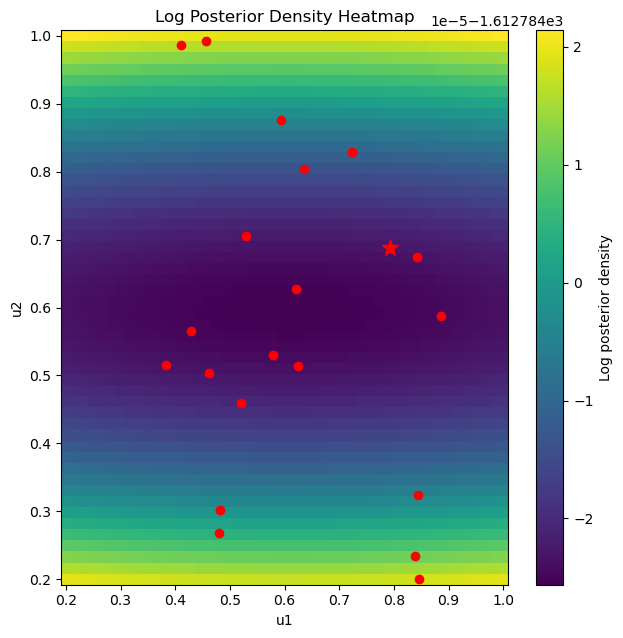

In [62]:
plt.figure(figsize=(7.2, 7.2))
pcm = plt.pcolormesh(U1, U2, predictive_mean.reshape(n_test_1d, n_test_1d), shading='auto', cmap='viridis')
plt.plot(design.X[:,0], design.X[:,1], "o", color="red")
plt.plot(*likelihood.par_true, "*", color="red", markersize=12)
plt.title("Log Posterior Density Heatmap")
plt.xlabel("u1")
plt.ylabel("u2")
plt.colorbar(pcm, label="Log posterior density")
plt.show()

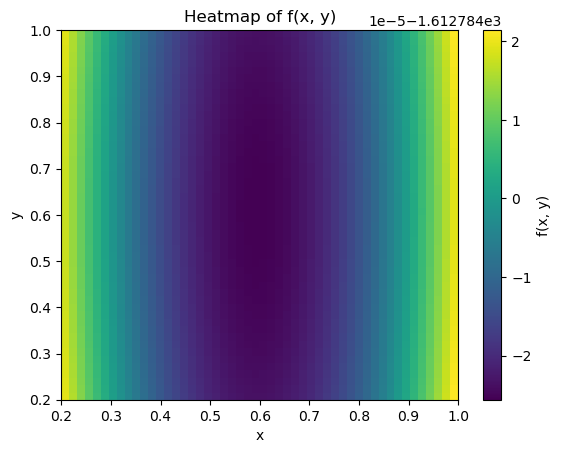

In [65]:
plt.imshow(predictive_mean.reshape(n_test_1d, n_test_1d), origin='lower', 
           extent=[u1_supp[0], u1_supp[1], u2_supp[0], u2_supp[1]], 
           cmap='viridis', aspect='auto')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='f(x, y)')
plt.title('Heatmap of f(x, y)')
plt.show()